In [93]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

pd.set_option('display.max_columns', None)

# 1. Data Prep

We'll load the data into a pandas dataframe. We rename the given variable names with names that are more descriptive.

'mom_iq', 'mom_age_at_childbirth', and 'child_iq' can reasonably be considered continuous-valued and are hence float-types, while 'mom_high_school' and 'mom_work_status' are boolean and categorical, respectively, which can be respresented by integers.

It's easiest to load everything as floats, although we will want to transform 'mom_work_status' later so that it actually makes sense to use it in a regression model. Also, we are reducing the precision of 'mom_iq' from 12 decimals to 8 decimals, but for a variable whose range is at least 50, there's no need for 12 digits of precision.

In [94]:
variable_dict = {'i': [], 'a': [], 'h': [], 'w': [], 'score': []}

with open('data.txt', 'r') as file:
    next(file)  # skip header line
    for line in file:
        chunks = line.replace('\n', '').replace('\'', '').split('|')  # [line number, variable, value]

        try:
            int(chunks[0]), float(chunks[2])  # check that line number and value are appropriate types
        except ValueError:
            print(f'Value error on line labeled {chunks[0]}. Skipping.')
            continue

        variable_dict[chunks[1]].append(float(chunks[2]))

data = pd.DataFrame(variable_dict, index=list(range(len(variable_dict['i']))))

data = data.rename(columns={
    'i': 'mom_iq',
    'a': 'mom_age_at_childbirth',
    'h': 'mom_high_school',
    'w': 'mom_work_status',
    'score': 'child_iq'
})

data.head()

Value error on line labeled 0xC0. Skipping.


,mom_iq,mom_age_at_childbirth,mom_high_school,mom_work_status,child_iq
0,121.117529,27.0,1.0,4.0,65.0
1,89.361882,25.0,1.0,4.0,98.0
2,115.443165,27.0,1.0,4.0,85.0
3,99.449639,25.0,1.0,3.0,83.0
4,92.745710,27.0,1.0,4.0,115.0


In [95]:
data.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 434 entries, 0 to 433
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   mom_iq                 434 non-null    float64
 1   mom_age_at_childbirth  434 non-null    float64
 2   mom_high_school        434 non-null    float64
 3   mom_work_status        434 non-null    float64
 4   child_iq               434 non-null    float64
dtypes: float64(5)
memory usage: 20.3 KB


We don't have to worry about filling any NaNs.

# 2. Data Transformation 

We need to transform 'mom_work_status' because there's no sense in which e.g. status=4 has twice the value of status=2. We'll one-hot encode this variable.

In [96]:
data[['mom_high_school', 'mom_work_status']] = data[['mom_high_school', 'mom_work_status']].astype(int)

data = pd.get_dummies(data, columns=['mom_work_status'], prefix='mom_work_status')
data.head()

,mom_iq,mom_age_at_childbirth,mom_high_school,child_iq,mom_work_status_1,mom_work_status_2,mom_work_status_3,mom_work_status_4
0,121.117529,27.0,1,65.0,0,0,0,1
1,89.361882,25.0,1,98.0,0,0,0,1
2,115.443165,27.0,1,85.0,0,0,0,1
3,99.449639,25.0,1,83.0,0,0,1,0
4,92.745710,27.0,1,115.0,0,0,0,1


I would consider data normalization to be part of this section, but we'll save that for after the EDA because we need to see the variables' distributions before e.g. dropping outliers.

# 3. EDA

Let's visualize the variable distributions:

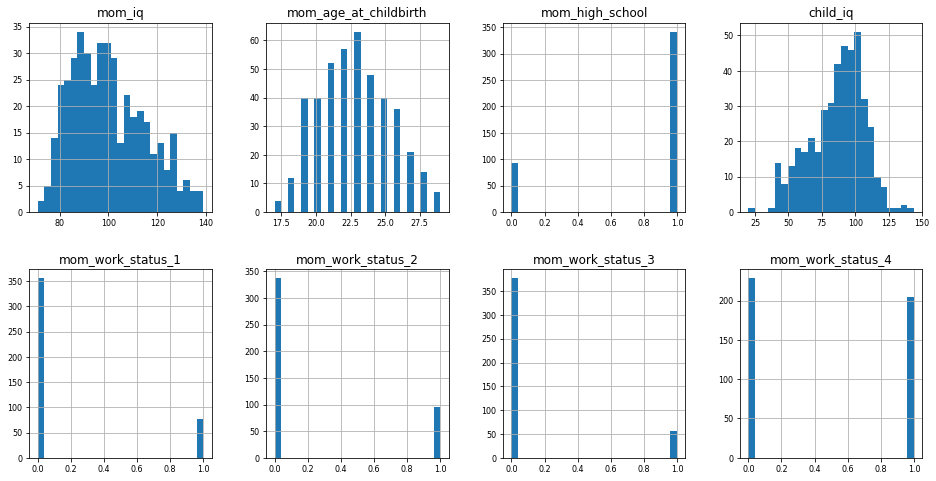

In [97]:
data.hist(figsize=(16, 8), bins=25, layout=(2,4), xlabelsize=8, ylabelsize=8);

The numerical features are relatively Gaussian-distributed, which justifies using standardization on them. The boolean features are mostly somewhat imbalanced, which is to be expected after one-hot encoding, but they still each have significant representation.

Now we'll visualize single-variable relationships with the dependent variable.

First with the numerical features:

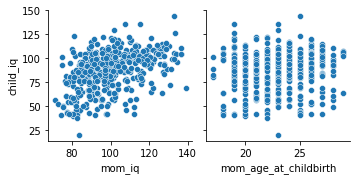

In [98]:
sns.pairplot(
    data=data,
    x_vars=['mom_iq', 'mom_age_at_childbirth'],
    y_vars=['child_iq']
);

And now with the boolean independent variables:

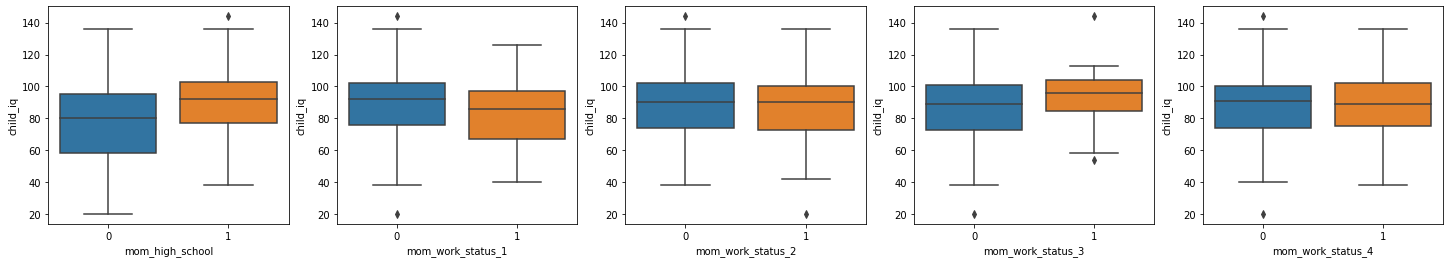

In [99]:
_, axs = plt.subplots(1, 5, figsize=(25,4))
for idx, cat_var in enumerate(['mom_high_school'] + ['mom_work_status_'+str(i) for i in range(1,5)]): 
    sns.boxplot(
        ax=axs[idx],
        data=data,
        x=cat_var, 
        y='child_iq', 
    );

'child_iq' under 25 or over 140 seems to be outlying in several boolean-numerical input-output plots, as well as somewhat qualitatively-outlying in the numerical-numerical input-output plots. Let's drop these data points. 

In [100]:
data.loc[(data.child_iq < 25) | (data.child_iq > 140)]

,mom_iq,mom_age_at_childbirth,mom_high_school,child_iq,mom_work_status_1,mom_work_status_2,mom_work_status_3,mom_work_status_4
135,132.865337,25.0,1,144.0,0,0,1,0
285,83.533119,23.0,0,20.0,0,1,0,0


In [101]:
data_clean = data.drop([135, 285])  # dropping the two outlier rows

Now we'll standardize the numerical features. This helps gradient descent converge faster because all feature values are of similar scale. It also helps us compare regression coefficients to each other as a means of establishing relative feature importances.

In [102]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(data_clean[['mom_iq', 'mom_age_at_childbirth']], data_clean.child_iq)
scaled_num_data = scaler.transform(data_clean[['mom_iq', 'mom_age_at_childbirth']])

data_final = data_clean.copy()
data_final.mom_iq = scaled_num_data[:,0]
data_final.mom_age_at_childbirth = scaled_num_data[:,1]

data_final.head()

,mom_iq,mom_age_at_childbirth,mom_high_school,child_iq,mom_work_status_1,mom_work_status_2,mom_work_status_3,mom_work_status_4
0,1.418613,1.561732,1,65.0,0,0,0,1
1,-0.710810,0.821558,1,98.0,0,0,0,1
2,1.038110,1.561732,1,85.0,0,0,0,1
3,-0.034360,0.821558,1,83.0,0,0,1,0
4,-0.483902,1.561732,1,115.0,0,0,0,1


Finally, let's look at correlations between numerical features:

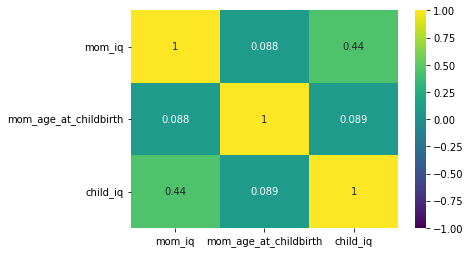

In [103]:
corr = data_final[['mom_iq', 'mom_age_at_childbirth', 'child_iq']].corr()

sns.heatmap(corr, cmap='viridis', vmax=1.0, vmin=-1.0, annot=True);

'mom_iq' is much more correlated with 'child_iq' than 'mom_age_at_childbirth' is, so we'll use 'mom_iq' for our single-variable linear regression model. 

# 4. Linear Regression Models

We'll be using linear regression to model the relationship between mothers' traits/characteristics and child IQ.

Recall that the assumptions of linear regression include
- **Linear relationship** between the independent and dependent variables
- **Homoscedasticity,** i.e. variance in residuals is the same for any subset of X
- **Independence** of observations
- **Normality** in the distribution of residuals

### 4.1 Single Predictor

We established above that we'll use 'mom_iq' for our single-variable regressor.

In [104]:
import statsmodels.api as sm

Y_1var = data_final.child_iq
X_1var = sm.add_constant(data_final.mom_iq)

model_1var = sm.OLS(Y_1var, X_1var).fit()
model_1var.summary()

c:\Users\2016f\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               child_iq   R-squared:                       0.192
Model:                            OLS   Adj. R-squared:                  0.190
Method:                 Least Squares   F-statistic:                     102.2
Date:                Mon, 16 Jan 2023   Prob (F-statistic):           1.05e-21
Time:                        16:29:06   Log-Likelihood:                -1860.9
No. Observations:                 432   AIC:                             3726.
Df Residuals:                     430   BIC:                             3734.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         86.8194      0.867    100.191      0.000      85.116      88.523
mom_iq         8.7619      0.867     10.111      0.000       7.059      10.465
==============================================================================
Omnibus:                        7.065   Durbin-Watson:                   1.646
Prob(Omnibus):                  0.029   Jarque-Bera (JB):                7.240
Skew:                          -0.304   Prob(JB):                       0.0268
Kurtosis:                       2.823   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We see R^2 = 0.192, indicating a (weak) positive correlation between 'mom_iq' and 'child_iq'. 

Indeed, the coefficient on 'mom_iq' of 8.76 indicates an estimated 8.76-point child IQ increase for each standard deviation increase in the mother's IQ, given our input scaling.

const = 86.8 indicates that a mother with 0 IQ would have a child with IQ = 86.8. This is a bit of an undesirable trait of the model, but we could just say that the model can only be valid for mom_iq > C where C is some value greater than 0.

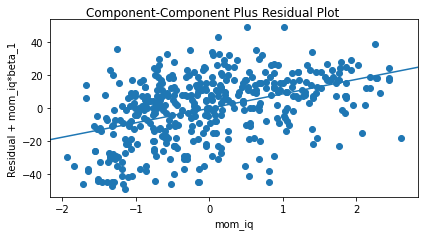

In [105]:
res_1var = plt.figure(figsize=(6, 6))
sm.graphics.plot_ccpr_grid(model_1var, fig=res_1var);

Here, we plot a partial residual plot as our primary diagnostic. The partial residual for 'mom_iq' are scattered wth no discernable pattern and relatively uniformly around a positive linear fit, so we can assume that the regression assumptions are met.

### 4.2 Multiple Predictors

Now we have 6 features for linear regression: 'mom_iq', 'mom_age_at_childbirth', 'mom_high_school', and work statuses 2, 3, and 4. (We drop the first one and designate it as a reference -- it is embedded in the model's additive constant.)

In [106]:
Y_multivar = data_final.child_iq
X_multivar = sm.add_constant(data_final.drop(columns=['child_iq', 'mom_work_status_1']))

model_multivar = sm.OLS(Y_multivar, X_multivar).fit()
model_multivar.summary()

c:\Users\2016f\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               child_iq   R-squared:                       0.211
Model:                            OLS   Adj. R-squared:                  0.200
Method:                 Least Squares   F-statistic:                     18.92
Date:                Mon, 16 Jan 2023   Prob (F-statistic):           1.49e-19
Time:                        16:29:06   Log-Likelihood:                -1855.8
No. Observations:                 432   AIC:                             3726.
Df Residuals:                     425   BIC:                             3754.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    80.7842      2.473     32.661      0.000      75.923      85.646
mom_iq                    8.0361      0.907      8.858      0.000       6.253       9.819
mom_age_at_childbirth     0.6343      0.890      0.712      0.477      -1.116       2.385
mom_high_school           4.8262      2.305      2.094      0.037       0.296       9.356
mom_work_status_2         3.6788      2.786      1.320      0.187      -1.798       9.155
mom_work_status_3         5.1024      3.223      1.583      0.114      -1.232      11.437
mom_work_status_4         1.6401      2.485      0.660      0.510      -3.244       6.524
==============================================================================
Omnibus:                        6.152   Durbin-Watson:                   1.616
Prob(Omnibus):                  0.046   Jarque-Bera (JB):                6.259
Skew:                          -0.277   Prob(JB):                       0.0437
Kurtosis:                       2.800   Cond. No.                         7.36
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

R^2 has increased marginally to 0.211 -- still a weak positive correlation. Interestingly, the influences of 'mom_age_at_childbirth' and the work statuses are not significant at p=0.05.

However, 'mom_iq' remains signficant, as is 'mom_high_school'. A child is predicted to have a 4.8-point increase in IQ if the mother completed high school. 

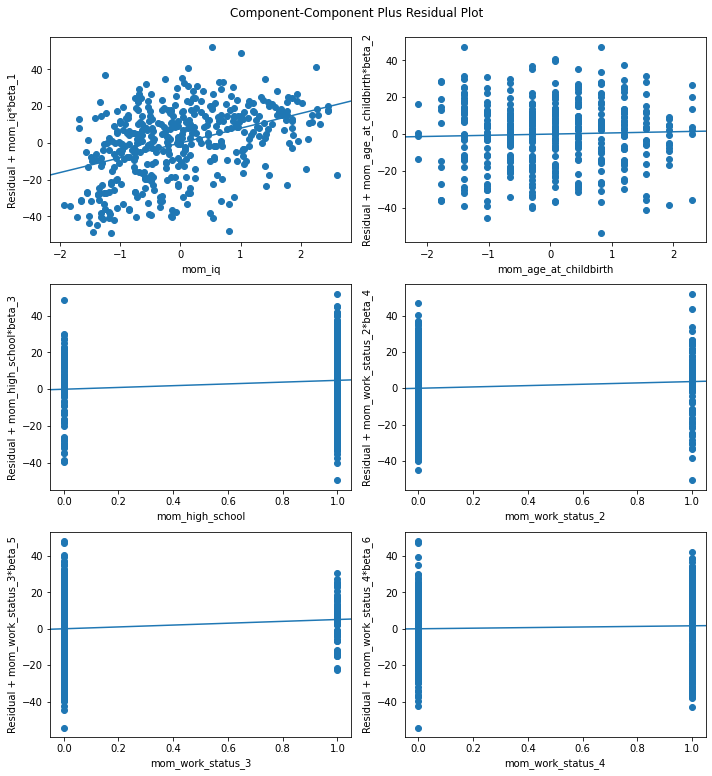

In [107]:
res_multivar = plt.figure(figsize=(10, 14))
sm.graphics.plot_ccpr_grid(model_multivar, fig=res_multivar);

### 4.3 Multiple Predictors with Interaction Term

All we will do here is tack on an interaction term to the previous model.

Let's include an interaction between 'mom_iq' and 'mom_age_at_childbirth' -- perhaps education combined with age is a better predictor of child IQ than either is individually?

In [108]:
data_final['mom_iq_hs_interaction'] = [iq*hs for iq, hs in zip(data_final.mom_iq, data_final.mom_high_school)]

In [109]:
Y_interaction = data_final.child_iq
X_interaction = sm.add_constant(data_final.drop(columns=['child_iq', 'mom_work_status_1']))

model_interaction = sm.OLS(Y_interaction, X_interaction).fit()
model_interaction.summary()

c:\Users\2016f\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               child_iq   R-squared:                       0.226
Model:                            OLS   Adj. R-squared:                  0.213
Method:                 Least Squares   F-statistic:                     17.71
Date:                Mon, 16 Jan 2023   Prob (F-statistic):           1.24e-20
Time:                        16:29:08   Log-Likelihood:                -1851.6
No. Observations:                 432   AIC:                             3719.
Df Residuals:                     424   BIC:                             3752.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    84.5476      2.773     30.487      0.000      79.097      89.999
mom_iq                   13.9193      2.216      6.281      0.000       9.564      18.275
mom_age_at_childbirth     0.9316      0.889      1.048      0.295      -0.815       2.678
mom_high_school           1.8240      2.508      0.727      0.467      -3.105       6.753
mom_work_status_2         2.6357      2.785      0.946      0.345      -2.839       8.111
mom_work_status_3         4.5354      3.201      1.417      0.157      -1.756      10.827
mom_work_status_4         1.0232      2.472      0.414      0.679      -3.837       5.883
mom_iq_hs_interaction    -7.0739      2.435     -2.905      0.004     -11.860      -2.287
==============================================================================
Omnibus:                        7.064   Durbin-Watson:                   1.655
Prob(Omnibus):                  0.029   Jarque-Bera (JB):                7.256
Skew:                          -0.310   Prob(JB):                       0.0266
Kurtosis:                       2.860   Cond. No.                         7.93
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Now that we have an interaction between mom IQ and her high school status, age by itself is no longer significant, but IQ by itself has become more significant -- the coefficient is up from 8.03 to 13.92.

The interaction between IQ and high school status is also signficant; interestingly, the negative coefficient implies that the positive correlation of child IQ and mom IQ is lessened when conditioned on the mother completing high school.

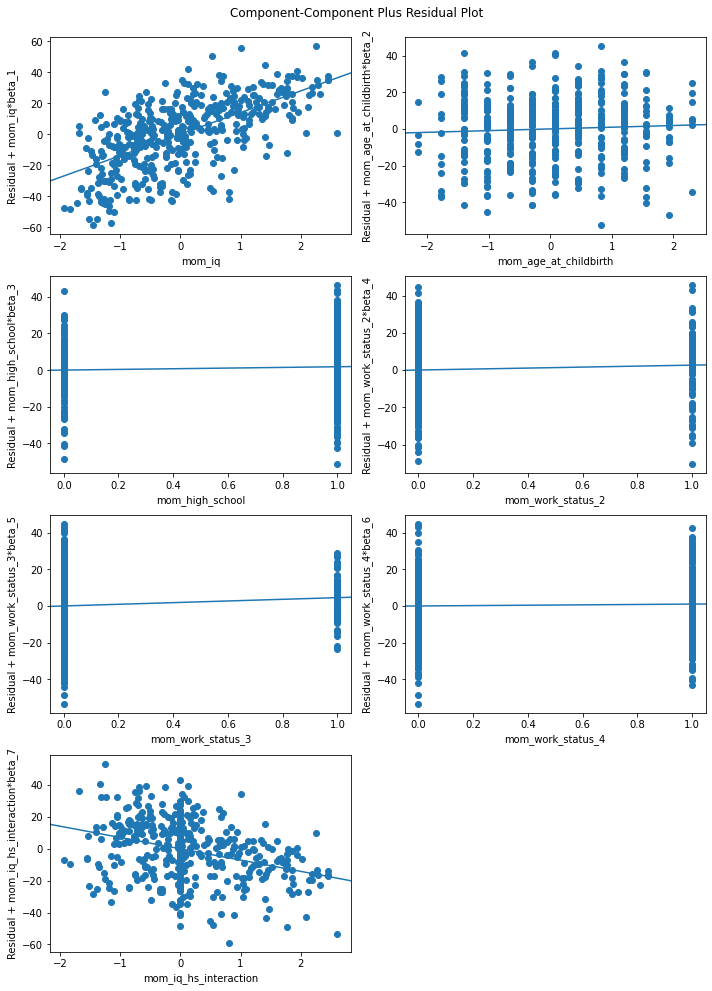

In [110]:
res_interaction = plt.figure(figsize=(10, 14))
sm.graphics.plot_ccpr_grid(model_interaction, fig=res_interaction);